In [64]:
%matplotlib inline
import numpy as np
import importlib as imp
#from importlib import reload # for python 3

"""
Simulation and GP-CaKe packages.
"""

import simulator as sim
import gpcake
import utility
import matplotlib.pyplot as plt

In [75]:
p                       = 3
adj_mat                 = np.zeros((p,p))
adj_mat[0,1]            = 1
#adj_mat[1,2]            = 1
connection_strength     = 5.0
time_step               = 0.01
time_period             = 4.
time_range              = np.arange(-time_period / 2, time_period / 2, time_step)
n                       = int(time_period / time_step)
simulation_params       = {'network'                : adj_mat,
                           'connection_strength'    : connection_strength,
                           'time_step'              : time_step,
                           'time_period'            : time_period}

ntrials_train                                       = 50
ntrials_test                                        = 50
simulation                                          = sim.integroDifferential_simulator()
simulation.dynamic_parameters["connectivity_relaxations_constants"] = [[0.0,8.0],[8.0,0.0]]
connectivity_relaxation = 10.
(training_samples, testing_samples, ground_truth)   = simulation.simulate_network_dynamics(ntrials_train, 
                                                                                           ntrials_test, 
                                                                                           simulation_params,
                                                                                           connectivity_relaxation = connectivity_relaxation)

Plot a few samples to see the generated time series.

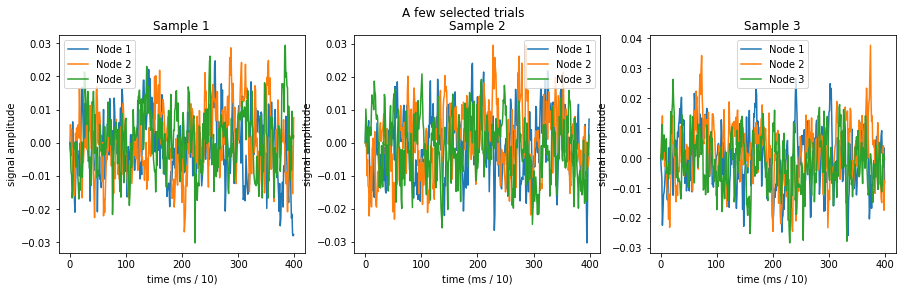

In [66]:
utility.plot_samples(training_samples[0:3])

In [191]:
reload(gpcake)
reload(utility)
cake = gpcake.gpcake()
cake.initialize_time_parameters(time_step, time_period)
cake.dynamic_parameters["number_sources"] = p
cake.dynamic_type = "Relaxation"

In [192]:
cake.dynamic_parameters = simulation.dynamic_parameters

In [193]:
parameter_dict = cake.empirical_bayes_parameter_fit(training_samples)
# Note: our analysis fails if p=2, which induces symmetric log-likelihood ratios and scales,
# which causes their std to be 0 and hence the normalization throws an error.

[0.5577138282165085, 0.5577138282165085, 0.79092184722335723, 0.5577138282165085, 0.5577138282165085, 0.5577138282165085]


In [194]:
nu = parameter_dict['time_scale']
G = parameter_dict['structural_connectivity']
sigma = parameter_dict['noise_level']
print nu
print G
print sigma

0.0455878191495
[[0 0 0]
 [1 0 0]
 [0 0 0]]
0.557713828217


Serial implementation.


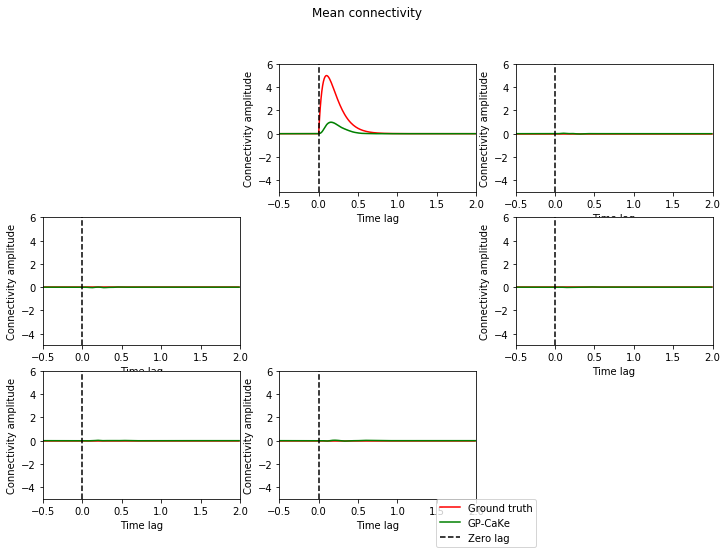

In [169]:

t_s    = 0.05   # temporal offset / time shift
theta  = np.pi  # temporal localization

cake.covariance_parameters = {  "time_scale"        : nu,     # Temporal smoothing
                                "time_shift"        : t_s,     # Temporal offset
                                "causal"            : "yes",    # Hilbert transform
                                "spectral_smoothing": theta }   # Temporal localization
cake.noise_level = sigma

connectivity = cake.run_analysis(testing_samples)
utility.plot_connectivity(ground_truth, connectivity, time_range, t0=-0.5)
